# 01.1b: Extract Causal Metric Tensor (M)

**Goal:** Compute the causal metric tensor following Park et al. (2024) and extract its eigenstructure.

The causal metric tensor **M** = Cov(γ')^(-1) describes the intrinsic geometry of the token space. It tells us how to measure distances in "logometers" (log-probability units) rather than raw gamma units.

We'll compute:
1. The covariance matrix Cov(γ') (2,560 × 2,560)
2. The causal metric tensor **M** = Cov(γ')^(-1) with Tikhonov regularization
3. Eigendecomposition: M = Q Λ Q^T
4. Save M, Q (eigenvectors), and Λ (eigenvalues)

## Mathematical Background

Following Park et al. (2024), the causal metric tensor is:

$$M = \text{Cov}(\gamma')^{-1}$$

where the covariance matrix is:

$$\text{Cov}(\gamma') = \frac{1}{N-1} \gamma'^T \gamma'$$

For numerical stability, we use Tikhonov regularization:

$$M = (\text{Cov}(\gamma') + \lambda I)^{-1}$$

The eigendecomposition M = Q Λ Q^T gives us:
- **Q**: Orthonormal eigenvectors (the "causal basis")
- **Λ**: Diagonal matrix of eigenvalues

These let us transform to causal coordinates: **z** = √Λ Q^T γ'

## Parameters

In [1]:
TENSOR_DIR = "../data/tensors"
REGULARIZATION_LAMBDA = 1e-6  # Tikhonov regularization parameter

## Imports

In [2]:
import torch
from safetensors.torch import load_file, save_file
from pathlib import Path
import matplotlib.pyplot as plt

print("Imports loaded successfully.")

Imports loaded successfully.


## Step 1: Load Centered Gamma

In [3]:
gamma_centered_path = Path(TENSOR_DIR) / "gamma_centered_qwen3_4b_instruct_2507.safetensors"
gamma_centered = load_file(gamma_centered_path)['gamma_centered']

print(f"Loaded γ' (gamma_centered):")
print(f"  Shape: {gamma_centered.shape}")
print(f"  Dtype: {gamma_centered.dtype}")
print(f"  Memory: {gamma_centered.element_size() * gamma_centered.nelement() / 1024**2:.1f} MB")

Loaded γ' (gamma_centered):
  Shape: torch.Size([151936, 2560])
  Dtype: torch.float32
  Memory: 1483.8 MB


## Step 2: Compute Covariance Matrix

In [4]:
# Cov(γ') = (1/(N-1)) * γ'^T @ γ'
N = gamma_centered.shape[0]
d = gamma_centered.shape[1]

print(f"Computing covariance matrix for {N:,} tokens in {d:,}D space...")
print(f"Output will be {d} × {d} = {d*d:,} elements")
print(f"Estimated memory: {d * d * 4 / 1024**2:.1f} MB (float32)\n")

cov = (gamma_centered.T @ gamma_centered) / (N - 1)

print(f"Covariance matrix computed:")
print(f"  Shape: {cov.shape}")
print(f"  Diagonal mean: {cov.diagonal().mean().item():.6f}")
print(f"  Diagonal std: {cov.diagonal().std().item():.6f}")
print(f"  Trace: {cov.trace().item():.4f}")

Computing covariance matrix for 151,936 tokens in 2,560D space...
Output will be 2560 × 2560 = 6,553,600 elements
Estimated memory: 25.0 MB (float32)

Covariance matrix computed:
  Shape: torch.Size([2560, 2560])
  Diagonal mean: 0.000437
  Diagonal std: 0.000031
  Trace: 1.1175


## Step 3: Compute Causal Metric Tensor with Regularization

In [5]:
# M = (Cov(γ') + λI)^(-1)
print(f"Adding Tikhonov regularization: λ = {REGULARIZATION_LAMBDA}")

cov_regularized = cov + REGULARIZATION_LAMBDA * torch.eye(d, dtype=cov.dtype, device=cov.device)

print(f"Inverting regularized covariance matrix...")
M = torch.linalg.inv(cov_regularized)

print(f"\nCausal metric tensor M computed:")
print(f"  Shape: {M.shape}")
print(f"  Diagonal mean: {M.diagonal().mean().item():.6f}")
print(f"  Diagonal std: {M.diagonal().std().item():.6f}")
print(f"  Trace: {M.trace().item():.4f}")

Adding Tikhonov regularization: λ = 1e-06
Inverting regularized covariance matrix...

Causal metric tensor M computed:
  Shape: torch.Size([2560, 2560])
  Diagonal mean: 2713.616699
  Diagonal std: 1543.585815
  Trace: 6946858.5000


## Step 4: Eigendecomposition

In [6]:
print("Computing eigendecomposition of M...")
eigenvalues, eigenvectors = torch.linalg.eigh(M)

# Sort in descending order (largest eigenvalue first)
idx = eigenvalues.argsort(descending=True)
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

print(f"\nEigendecomposition complete:")
print(f"  Eigenvectors Q shape: {eigenvectors.shape}")
print(f"  Eigenvalues Λ shape: {eigenvalues.shape}")
print(f"\nEigenvalue statistics:")
print(f"  Largest: {eigenvalues[0].item():.4f}")
print(f"  Smallest: {eigenvalues[-1].item():.4f}")
print(f"  Mean: {eigenvalues.mean().item():.4f}")
print(f"  Std: {eigenvalues.std().item():.4f}")
print(f"  Ratio (max/min): {(eigenvalues[0] / eigenvalues[-1]).item():.2f}")

Computing eigendecomposition of M...

Eigendecomposition complete:
  Eigenvectors Q shape: torch.Size([2560, 2560])
  Eigenvalues Λ shape: torch.Size([2560])

Eigenvalue statistics:
  Largest: 94217.0859
  Smallest: 95.3442
  Mean: 2713.6167
  Std: 2603.7300
  Ratio (max/min): 988.18


## Step 5: Visualize Eigenvalue Spectrum

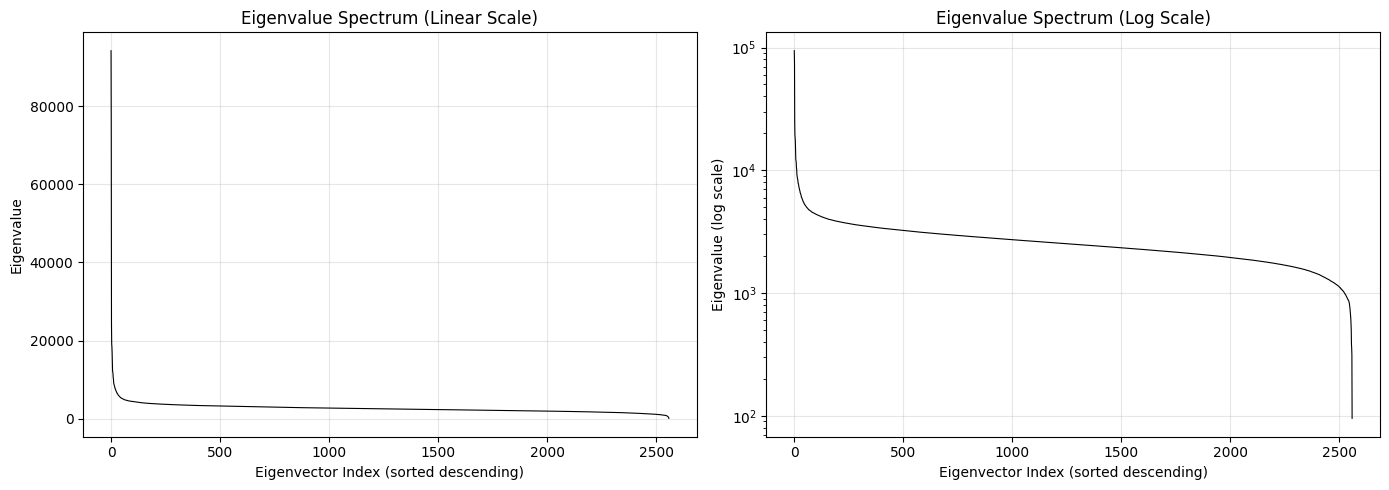

Eigenvalue spectrum shows the relative importance of each causal dimension.


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=100)

# Linear scale
axes[0].plot(eigenvalues.cpu().numpy(), linewidth=0.8, color='black')
axes[0].set_xlabel('Eigenvector Index (sorted descending)')
axes[0].set_ylabel('Eigenvalue')
axes[0].set_title('Eigenvalue Spectrum (Linear Scale)')
axes[0].grid(True, alpha=0.3)

# Log scale
axes[1].semilogy(eigenvalues.cpu().numpy(), linewidth=0.8, color='black')
axes[1].set_xlabel('Eigenvector Index (sorted descending)')
axes[1].set_ylabel('Eigenvalue (log scale)')
axes[1].set_title('Eigenvalue Spectrum (Log Scale)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Eigenvalue spectrum shows the relative importance of each causal dimension.")

## Step 6: Compute Condition Number

In [8]:
# Condition number = ratio of largest to smallest eigenvalue
condition_number = eigenvalues[0] / eigenvalues[-1]

print(f"Condition number of M: {condition_number.item():.2e}")
print(f"\nThis tells us how 'stretched' the causal space is.")
print(f"A condition number of {condition_number.item():.1f} means the most important")
print(f"dimension is ~{condition_number.item():.1f}× more important than the least.")

Condition number of M: 9.88e+02

This tells us how 'stretched' the causal space is.
A condition number of 988.2 means the most important
dimension is ~988.2× more important than the least.


## Step 7: Save Everything

In [10]:
# Save causal metric tensor M
M_path = Path(TENSOR_DIR) / "causal_metric_M.safetensors"
save_file({'M': M.contiguous()}, M_path)
print(f"Saved M to: {M_path}")

# Save eigenvectors Q
Q_path = Path(TENSOR_DIR) / "causal_eigenvectors_Q.safetensors"
save_file({'Q': eigenvectors.contiguous()}, Q_path)
print(f"Saved Q to: {Q_path}")

# Save eigenvalues Λ
Lambda_path = Path(TENSOR_DIR) / "causal_eigenvalues_Lambda.safetensors"
save_file({'Lambda': eigenvalues.contiguous()}, Lambda_path)
print(f"Saved Λ to: {Lambda_path}")

# Save covariance matrix too (might be useful)
cov_path = Path(TENSOR_DIR) / "gamma_covariance.safetensors"
save_file({'covariance': cov.contiguous()}, cov_path)
print(f"Saved Cov(γ') to: {cov_path}")

Saved M to: ../data/tensors/causal_metric_M.safetensors
Saved Q to: ../data/tensors/causal_eigenvectors_Q.safetensors
Saved Λ to: ../data/tensors/causal_eigenvalues_Lambda.safetensors
Saved Cov(γ') to: ../data/tensors/gamma_covariance.safetensors


## Summary

Successfully computed the causal metric tensor and its eigenstructure. We now have:

- **M** (causal_metric_M): The 2,560 × 2,560 metric tensor
- **Q** (causal_eigenvectors_Q): Orthonormal eigenvectors defining the causal basis
- **Λ** (causal_eigenvalues_Lambda): Eigenvalues showing importance of each dimension
- **Cov(γ')** (gamma_covariance): The original covariance matrix

These let us transform between gamma space and causal space:
- **To causal coordinates:** z = √Λ Q^T γ'
- **Back to gamma space:** γ' = Q Λ^(-1/2) z

Future notebooks can use these to explore geometry in both coordinate systems.